In [1]:
# please make sure your drive_path is set, so that the notebook can find the data files on the hard drive

# OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/cell_types_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/cell_types_cache/'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/cell_types_cache/'

# AWS
drive_path = '/data/dynamic-brain-workshop/cell_types_cache/'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from GLM_helpers import *
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input

from allensdk.core.cell_types_cache import CellTypesCache

Using TensorFlow backend.


In [3]:
ctc = CellTypesCache()

In [4]:
# pd.DataFrame(ctc.get_cells()).head()
cells = pd.DataFrame(ctc.get_cells(reporter_status='positive'))
print len(cells)
# cells.head()
# print cells.groupby(by='transgenic_line').size()
region = 'VISp'

inh_lines = []
exc_lines = []
exc_st = ['Rorb','Scnn','Nr5','Rbp','Emx','Cux','Tlx3','Sim1','Ntsr']
inh_st = ['Gad','Htr','Pvalb','Vip','Sst']
for line in cells.transgenic_line.unique():
    for st in exc_st:
        if line.startswith(st):
            exc_lines.append(line)
    for st in inh_st:
        if line.startswith(st):
            inh_lines.append(line)


has_line = False
# lines = ['Rorb-IRES2-Cre']
for line in inh_lines:
    has_line = has_line | (cells.transgenic_line==line)
inh_cells = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev==region) & (cells.structure_layer_name=='5')]
print len(inh_cells)

for line in exc_lines:
    has_line = has_line | (cells.transgenic_line==line)
exc_cells = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev==region) & (cells.structure_layer_name=='5')]
print len(exc_cells)


1813
196
361


In [5]:
#for cell in cell_types_class ...
epd = ctc.get_ephys_data(cells['id'][0])

In [6]:
names = []
for i in epd.get_experiment_sweep_numbers():
    names.append(epd.get_sweep_metadata(i)['aibs_stimulus_name'])
print np.unique(names)

[u'Long Square' u'Noise 1' u'Noise 2' u'Ramp' u'Short Square'
 u'Square - 0.5ms Subthreshold' u'Square - 2s Suprathreshold' u'Test']


In [7]:
def get_sweeps_with_stim(ephys_data,stim_type):
    sweeps = []
    for i in ephys_data.get_experiment_sweep_numbers():
        if str.startswith(str(ephys_data.get_sweep_metadata(i)['aibs_stimulus_name']),stim_type):
            sweep = ephys_data.get_sweep(i)
            sweep['spike_times'] = ephys_data.get_spike_times(i)
            sweeps.append(sweep)
    return sweeps

def bin_spikes_and_stim(sweeps,bin_len,zpad=0):
    spikes_list = []
    stim_list = []
    for sweep in sweeps:
        T = int(np.floor(sweep['index_range'][1]*1.0/(sweep['sampling_rate']*bin_len)))
        binned_spikes = np.zeros((1,T))
        binned_stim = np.empty((1,T))
        for spike_time in sweep['spike_times']:
            t = int(np.floor(spike_time/bin_len))
            binned_spikes[0,t]+=1
        for i in range(T):
            binned_stim[0,i] = np.mean(sweep['stimulus'][int(np.round(i*bin_len*sweep['sampling_rate'])):int(np.round((i+1)*bin_len*sweep['sampling_rate']))])
        spikes_list.append(binned_spikes)
        stim_list.append(binned_stim)
        if zpad>0:
            spikes_list.append(np.zeros((1,int(np.floor(zpad/bin_len)))))
            stim_list.append(np.zeros((1,int(np.floor(zpad/bin_len)))))
    binned_spikes = np.hstack(spikes_list)
    binned_stim = np.hstack(stim_list)
    return (binned_spikes, binned_stim)
        

In [77]:
# Inputs:
# stimulus: video shown to the mouse in some form
# spikes: spikes recorded from each neuron in some form
# link: string for the link function used. options are {'log', 'logit'}
# priors: TODO
# L1: regularization parameter for sparse synapses TODO

# Returns:
# GLM network model with parameters fit

def GLM_network_fit(stimulus,spikes,d_stim, d_spk,link='log',priors=None,L1=None):
    N = spikes.shape[0]
    M = stimulus.shape[0]
    K = np.empty((N,M,d_stim)) # stimulus filters
    W = np.empty((N,N,d_spk))  # spike train filters
#     b = np.empty((N,)) # biases
    
    links = {'log':sm.genmod.families.links.log, 'logit':sm.genmod.families.links.logit}
    for i in range(N):
        [y, Xdsn] = construct_GLM_mat(stimulus,spikes,i, d_stim, d_spk)
        y = y.reshape((-1,1))
        # construct GLM model and return fit
        if priors is None and L1 is None:
            glm_pois = sm.GLM(y, Xdsn, family=sm.families.Poisson(link=links[link]))
            gfit = glm_pois.fit()
            p = gfit.params
            K[i,:,:] = p[:M*d_stim].reshape((M,d_stim))
            W[i,:,:] = p[M*d_stim:].reshape((N,d_spk))
#             W[i,:,:] = p[M*d_stim:-1].reshape((N,d_spk))
            #             b[i] = p[-1]

    return (K,W)
#     return (K,W,b)



# Inputs
# flat_stimulus: M x T matrix of stimuli
# binned_spikes: N x T matrix of spike counts
# i: index of the neuron we're constructing the matrix for
# d_stim: duration of stimulus filter (# time bins)
# d_spk: duration of spike filters (# time bins)
def construct_GLM_mat(flat_stimulus, binned_spikes, i, d_stim, d_spk):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
#     X_dsn = np.empty((T-d_stim,1+M*d_stim+N*d_spk))
    X_dsn = np.empty((T-d_stim,M*d_stim+N*d_spk))
    d_max = max(d_stim,d_spk)
    y = np.empty((T-d_max,))
    for t in range(T-d_max):
        y[t] = binned_spikes[i,t+d_max]
        X_dsn[t,:M*d_stim] = np.fliplr(flat_stimulus[:,t+d_max-d_stim:t+d_max]).reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d_stim:] = np.fliplr(binned_spikes[:,t+d_max-d_spk:t+d_max]).reshape((1,-1)) #spike inputs
#         X_dsn[t,M*d_stim:-1] = np.fliplr(binned_spikes[:,t+d_max-d_spk:t+d_max]).reshape((1,-1)) #spike inputs
        #         X_dsn[t,-1] = 1.0   #bias term
    return (y, X_dsn)   

In [148]:
sweeps = get_sweeps_with_stim(epd,'Noise')
bin_len = 0.0005
# bin_len = 0.005
i=0
(binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)

(37500, 1400999)
50000.0
['stimulus', 'index_range', 'spike_times', 'stimulus_unit', 'sampling_rate', 'response']


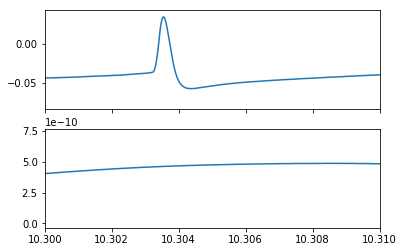

In [10]:

t = np.arange(0,sweeps[i]['index_range'][1]+1)*1.0/sweeps[i]['sampling_rate']
fig,ax = plt.subplots(2,1,sharex=True)
ax[1].plot(t,sweeps[i]['stimulus'])
ax[0].plot(t,sweeps[i]['response'])
plt.xlim(10.3,10.31)
print sweeps[5]['index_range']
print sweeps[5]['sampling_rate']
print sweeps[5].keys()


(10.3, 10.35)

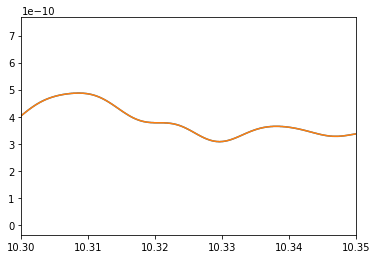

In [11]:
plt.plot(t,sweeps[i]['stimulus'])
plt.plot((np.arange(0,binned_stim.shape[1])+0.5)*bin_len,np.squeeze(binned_stim))
plt.xlim([10.3,10.35])

(10.3, 10.5)

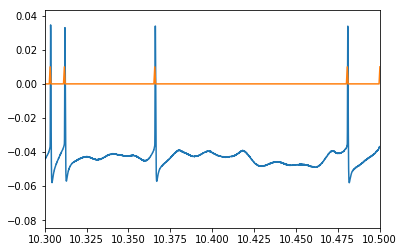

In [12]:
plt.plot(t,sweeps[i]['response'])
plt.plot((np.arange(0,binned_stim.shape[1])+0.5)*bin_len,np.squeeze(binned_spikes)*0.01)
plt.xlim([10.3,10.5])

(336184, 100)


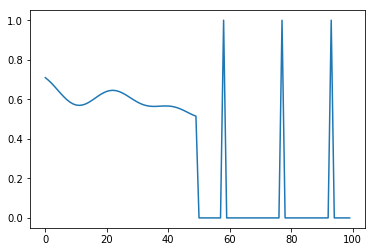

In [272]:
d = 50
(y,Xdsn) = construct_GLM_mat(binned_stim*1e9, binned_spikes, i, d, d)
print Xdsn.shape
# plt.imshow(Xdsn[20900:21000],aspect=0.1)
plt.plot(Xdsn[209090,:])

In [273]:
# from keras.engine.base_layer import Layer
# class FPrb(Layer):

#     def __init__(self,dt, **kwargs):
#         self.dt = dt
#         super(FPrb, self).__init__(**kwargs)

#     def build(self, input_shape):
#         # Create a trainable weight variable for this layer.
#         self.kernel = self.add_weight(name='kernel', 
#                                       shape=(input_shape[-1],1),
#                                       initializer='uniform',
#                                       trainable=True)
#         self.built = True

#     def call(self, x):
#         return K.exp(K.dot(x, self.kernel))*self.dt

#     def compute_output_shape(self, input_shape):
#         return (input_shape[0],)

In [274]:
# def negloglikelihood(y_true,y_pred):
#     return -(-y_pred+y_true*K.log(y_pred))

In [ ]:
# inp = Input(shape=(Xdsn.shape[1],))
# out = FPrb(bin_len)(inp)
# model = Model(inputs = [inp], outputs = [out])
# print model.summary()

In [276]:
# model.compile(loss = negloglikelihood,optimizer = 'sgd')

In [ ]:
# model.fit(x=Xdsn,y=np.expand_dims(y,1),epochs=10,batch_size = 400000)

In [ ]:
# p = model.get_weights()[0]
# plt.plot(p[d:])

In [ ]:
# plt.plot(np.exp(Xdsn[20000:20800,:].dot(p))*bin_len)
# print p.shape
# plt.plot(binned_spikes[0,20000+d:20800+d])

In [198]:
(F,W) = GLM_network_fit(binned_stim,binned_spikes,d, d)

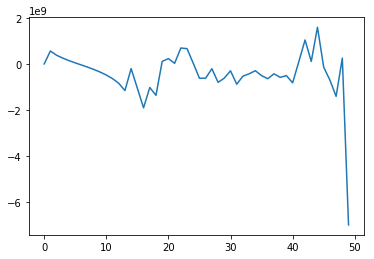

In [199]:
plt.plot(np.squeeze(F))

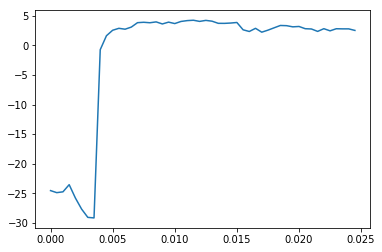

In [200]:
plt.plot(np.arange(d)*bin_len,np.squeeze(W))

In [ ]:
Fs = []
Ws = []
# bs = []
fig,ax = plt.subplots(2,1,sharex=True)

for sweeps in [get_sweeps_with_stim(ctc.get_ephys_data(c_id),'Noise') for c_id in exc_cells['id'][4:10]]:
    if len(sweeps)>0:
        (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)
        (F,W) = GLM_network_fit(binned_stim,binned_spikes,d, d)
        Fs.append(F)
        Ws.append(W)
#         bs.append(b)
        ax[0].plot(np.arange(d)*bin_len,np.squeeze(F))
        ax[1].plot(np.arange(d)*bin_len,np.squeeze(W))
print bs

In [101]:
print bin_len

0.0005
